In [1]:
import pandas as pd
import numpy as np
import pickle
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
chicago_crime = pickle.load(open('./data/chicago_crime.pickle', 'rb'))

In [3]:
chicago_crime_init = chicago_crime.copy()

In [4]:
chicago_crime.head()

,Date,Primary Type,Description,Location Description,Arrest,Domestic,Community Area,Year,Latitude,Longitude,Hour,Day,Month
60343,2019-01-03 19:00:00,PUBLIC PEACE VIOLATION,OTHER VIOLATION,AIRCRAFT,False,False,76,2019,42.002816,-87.906094,19,3,1
62270,2019-03-16 18:00:00,BATTERY,SIMPLE,STREET,False,False,32,2019,41.883369,-87.633860,18,16,3
62611,2019-03-12 22:00:00,THEFT,$500 AND UNDER,RESIDENTIAL YARD (FRONT/BACK),False,False,36,2019,41.825347,-87.606781,22,12,3
62644,2019-03-14 19:00:00,BATTERY,SIMPLE,RESIDENCE,False,False,1,2019,42.016542,-87.672499,19,14,3
62645,2019-03-14 16:00:00,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,True,36,2019,41.825299,-87.606961,16,14,3


In [5]:
chicago_crime.shape

(6956245, 13)

In [6]:
chicago_crime.isnull().sum()

Date                         0
Primary Type                 0
Description                  0
Location Description         0
Arrest                       0
Domestic                     0
Community Area          604237
Year                         0
Latitude                     0
Longitude                    0
Hour                         0
Day                          0
Month                        0
dtype: int64

Don't have community area as of yet, so removing it

In [7]:
chicago_crime.drop(columns='Community Area', inplace=True)

## Feature eng 

In [8]:
from fastai.tabular import add_datepart
import seaborn as sns
import matplotlib.pyplot as plt

### Non numerical variables

- **Date**

Adding information about date and time (day of week, week of year...)

In [9]:
# Uncomment for add_datepart source code
#??add_datepart

In [10]:
#X = add_datepart(X, 'Date')

In [11]:
#X.head()

In [12]:
#X.columns

can drop date

In [13]:
chicago_crime.drop(columns='Date', inplace=True)

In [14]:
chicago_crime['Description'].nunique()

380

- **Year**

Might have a too strong correlation between Year and Arrest because recent crimes have lower chance to be solved than older ones

In [15]:
arrest_per_year = chicago_crime.groupby(['Year', 'Arrest'])

In [17]:
arrest_per_year = arrest_per_year.count().reset_index()[['Year','Arrest', 'Hour']]

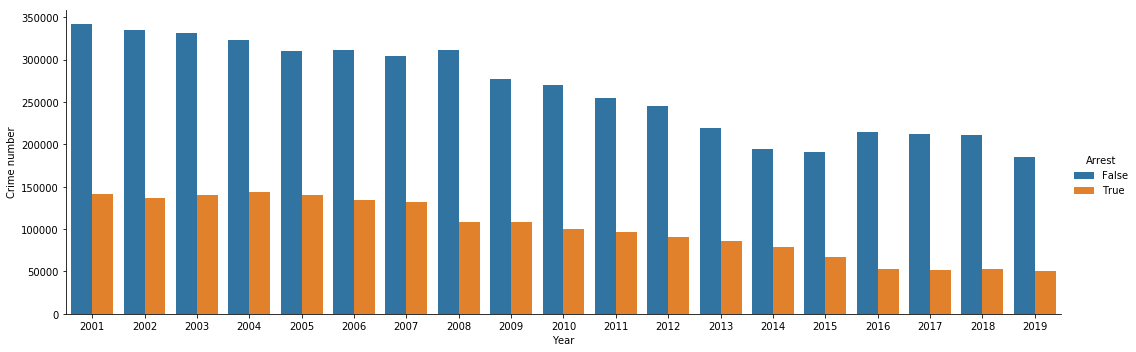

In [19]:
fig = sns.catplot( x= 'Year', y='Hour', hue='Arrest', data=arrest_per_year, kind='bar', height=5, aspect=3)
fig.set_axis_labels('Year', 'Crime number')
plt.show()

Looks ok (not too correlated)

- **Primary Type**

In [20]:
p_type = chicago_crime['Primary Type']

In [21]:
p_type.nunique()

35

In [22]:
p_type_vc = p_type.value_counts()
p_type_vc

THEFT                                1467564
BATTERY                              1278398
CRIMINAL DAMAGE                       795821
NARCOTICS                             716104
ASSAULT                               438180
OTHER OFFENSE                         433043
BURGLARY                              396848
MOTOR VEHICLE THEFT                   320719
DECEPTIVE PRACTICE                    271873
ROBBERY                               262757
CRIMINAL TRESPASS                     199584
WEAPONS VIOLATION                      76781
PROSTITUTION                           68380
PUBLIC PEACE VIOLATION                 49190
OFFENSE INVOLVING CHILDREN             45488
CRIM SEXUAL ASSAULT                    27426
SEX OFFENSE                            25217
INTERFERENCE WITH PUBLIC OFFICER       16664
GAMBLING                               14469
LIQUOR LAW VIOLATION                   14175
ARSON                                  11465
HOMICIDE                                9946
KIDNAPPING

We can regroup the types with less than 10000 crimes in OTHER

In [23]:
def regroup_low_fred(data, column, min_freq) :
    freq = data[column].value_counts()
    lowf_types = list(freq[freq <min_freq].index)
    data[column] = data[column].apply(lambda x : 'OTHER' if x in lowf_types else x)

In [26]:
regroup_low_fred(chicago_crime, 'Primary Type', 10000)

In [27]:
chicago_crime['Primary Type'].value_counts()

THEFT                               1467564
BATTERY                             1278398
CRIMINAL DAMAGE                      795821
NARCOTICS                            716104
ASSAULT                              438180
OTHER OFFENSE                        433043
BURGLARY                             396848
MOTOR VEHICLE THEFT                  320719
DECEPTIVE PRACTICE                   271873
ROBBERY                              262757
CRIMINAL TRESPASS                    199584
WEAPONS VIOLATION                     76781
PROSTITUTION                          68380
PUBLIC PEACE VIOLATION                49190
OFFENSE INVOLVING CHILDREN            45488
CRIM SEXUAL ASSAULT                   27426
OTHER                                 26099
SEX OFFENSE                           25217
INTERFERENCE WITH PUBLIC OFFICER      16664
GAMBLING                              14469
LIQUOR LAW VIOLATION                  14175
ARSON                                 11465
Name: Primary Type, dtype: int64

- **Description**

In [28]:
chicago_crime['Description'].nunique()

380

In [29]:
regroup_low_fred(chicago_crime, 'Description', 10000)

In [30]:
chicago_crime['Description'].nunique()

73

In [31]:
chicago_crime['Description'].value_counts()

SIMPLE                                             823486
$500 AND UNDER                                     566900
DOMESTIC BATTERY SIMPLE                            540670
OTHER                                              428422
TO VEHICLE                                         386303
TO PROPERTY                                        366932
OVER $500                                          360381
POSS: CANNABIS 30GMS OR LESS                       275887
FORCIBLE ENTRY                                     267977
AUTOMOBILE                                         252125
FROM BUILDING                                      236026
RETAIL THEFT                                       178064
TELEPHONE THREAT                                   137510
TO LAND                                            123556
POSS: CRACK                                        119259
UNLAWFUL ENTRY                                     106174
HARASSMENT BY TELEPHONE                            102238
AGGRAVATED: OT

- **Local Description**


In [32]:
chicago_crime['Location Description'].nunique()

180

In [33]:
regroup_low_fred(chicago_crime, 'Location Description', 10000 )

In [34]:
chicago_crime['Location Description'].nunique()

45

In [35]:
chicago_crime['Location Description'].value_counts()

STREET                               1816631
RESIDENCE                            1171048
APARTMENT                             727833
SIDEWALK                              682610
OTHER                                 416351
PARKING LOT/GARAGE(NON.RESID.)        200024
ALLEY                                 155305
SCHOOL, PUBLIC, BUILDING              144687
RESIDENCE-GARAGE                      134480
SMALL RETAIL STORE                    125923
RESIDENCE PORCH/HALLWAY               122273
RESTAURANT                            112262
VEHICLE NON-COMMERCIAL                111694
GROCERY FOOD STORE                     90456
DEPARTMENT STORE                       88306
GAS STATION                            75492
RESIDENTIAL YARD (FRONT/BACK)          74134
CHA PARKING LOT/GROUNDS                55649
PARK PROPERTY                          53349
COMMERCIAL / BUSINESS OFFICE           50330
BAR OR TAVERN                          38001
CTA PLATFORM                           37222
CHA APARTM

### Numericalize

In [36]:
from fastai.tabular import Categorify

Boolean columns need to be 0/1 instead of True/False

In [37]:
bool_vars = ['Domestic', 'Arrest']
for c in bool_vars :
    chicago_crime[c] = chicago_crime[c].astype(int)

Need to numercalie categorical variables 

In [38]:
cat_vars = ['Primary Type', 'Description', 'Location Description']
cont_vars = ['Domestic', 'Year', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month', 'Week',
       'Dayofweek', 'Dayofyear',
       'Elapsed']

In [39]:
cat_proc = Categorify(cat_vars, cont_vars)

In [41]:
cat_proc.apply_train(chicago_crime)

In [42]:
for c in cat_vars :
    chicago_crime[c] = chicago_crime[c].cat.codes

In [43]:
#pickle.dump(chicago_crime, open('data/chicago_crimes_processed.pkl', 'wb'))

In [2]:
chicago_crime = pickle.load(open('data/chicago_crimes_processed.pkl', 'rb'))

# Arrest prediction

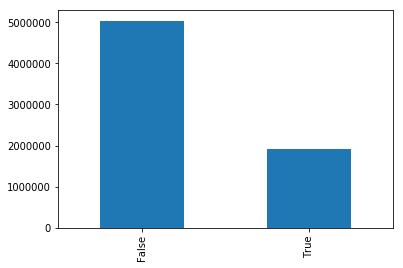

In [68]:
chicago_crime['Arrest'].map({1 : 'True', 0: 'False'}).value_counts().plot(kind='bar')
plt.show()

Dataset not very well balanced : we will use tree models (random forest/xgb)

In [48]:
indep_vars = ['Primary Type', 'Description', 'Location Description',
       'Domestic', 'Year', 'Latitude', 'Longitude', 'Hour',
       'Day', 'Month']
dep_var = 'Arrest'

In [49]:
X, y = chicago_crime[indep_vars], chicago_crime[dep_var]

In [50]:
X.head()

,Primary Type,Description,Location Description,Domestic,Year,Latitude,Longitude,Hour,Day,Month
60343,17,41,27,0,2019,42.002816,-87.906094,19,3,1
62270,2,55,41,0,2019,41.883369,-87.633860,18,16,3
62611,20,0,34,0,2019,41.825347,-87.606781,22,12,3
62644,2,55,31,0,2019,42.016542,-87.672499,19,14,3
62645,15,43,41,1,2019,41.825299,-87.606961,16,14,3


### Spitting train and valid

In [3]:
def get_sample(X, y,pctg=0.1) :
    permu = np.random.permutation(X.shape[0])
    idxs = permu[:int(pctg*X.shape[0])]
    return X.iloc[idxs], y.iloc[idxs]

In [53]:
X_sample, y_sample = get_sample(X, y, pctg=1)

In [4]:
from sklearn.model_selection import train_test_split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.1)

In [57]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6260620, 10), (695625, 10), (6260620,), (695625,))

In [58]:
X_train.head()

,Primary Type,Description,Location Description,Domestic,Year,Latitude,Longitude,Hour,Day,Month
91845,1,55,41,0,2019,41.896713,-87.625586,9,18,6
1791573,21,71,32,0,2002,41.967099,-87.719441,0,1,1
2169054,2,55,37,0,2002,41.884856,-87.763346,11,9,10
4548172,12,46,41,0,2008,41.752624,-87.563821,20,12,1
1921028,2,55,31,1,2002,41.675652,-87.632205,22,15,4


## Random forest (bagging)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [6]:
def print_score(model) :
    train_acc = model.score(X_train, y_train)
    valid_acc = model.score(X_test, y_test)
    train_f1 = f1_score(model.predict(X_train), y_train)
    valid_f1 = f1_score(model.predict(X_test), y_test)
    print("Train accuray : {:.3f}, Valid accuracy : {:.3f}, Train F1 score : {:.3f}, Valid F1 score : {:.3f}".format(train_acc, valid_acc, train_f1, valid_f1))

In [61]:
X.head()

,Primary Type,Description,Location Description,Domestic,Year,Latitude,Longitude,Hour,Day,Month
60343,17,41,27,0,2019,42.002816,-87.906094,19,3,1
62270,2,55,41,0,2019,41.883369,-87.633860,18,16,3
62611,20,0,34,0,2019,41.825347,-87.606781,22,12,3
62644,2,55,31,0,2019,42.016542,-87.672499,19,14,3
62645,15,43,41,1,2019,41.825299,-87.606961,16,14,3


In [62]:
rf = RandomForestClassifier(n_jobs=-1)

In [63]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [64]:
print_score(rf)

Train accuray : 0.986, Valid accuracy : 0.882, Train F1 score : 0.975, Valid F1 score : 0.753


In [65]:
pickle.dump((rf, cat_proc), open('data/randomforest.pkl', 'wb'))

## XBG (boosting)

In [88]:
from xgboost import XGBClassifier

In [89]:
xg = XGBClassifier(n_jobs=-1)

In [90]:
xg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='logloss', early_stopping_rounds=10, verbose=True)

[0]	validation_0-logloss:0.648242	validation_1-logloss:0.648311
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.611639	validation_1-logloss:0.611768
[2]	validation_0-logloss:0.581817	validation_1-logloss:0.581996
[3]	validation_0-logloss:0.554158	validation_1-logloss:0.554359
[4]	validation_0-logloss:0.53105	validation_1-logloss:0.53127
[5]	validation_0-logloss:0.51163	validation_1-logloss:0.511868
[6]	validation_0-logloss:0.495236	validation_1-logloss:0.495489
[7]	validation_0-logloss:0.481302	validation_1-logloss:0.481545
[8]	validation_0-logloss:0.469208	validation_1-logloss:0.469484
[9]	validation_0-logloss:0.458989	validation_1-logloss:0.459294
[10]	validation_0-logloss:0.449865	validation_1-logloss:0.450203
[11]	validation_0-logloss:0.442406	validation_1-logloss:0.44277
[12]	validation_0-logloss:0.435117	validation_1-logloss:0.435485
[13]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [91]:
print_score(xg)

Train accuray : 0.874, Valid accuracy : 0.873, Train F1 score : 0.726, Valid F1 score : 0.726


In [92]:
pickle.dump((xg, cat_proc), open('data/xgb.pkl', 'wb'))

## Feature importance

In [66]:
rf_feat_imp = pd.DataFrame({'Feature' : X.columns, 'importance' : rf.feature_importances_})
rf_feat_imp.sort_values('importance', inplace=True)

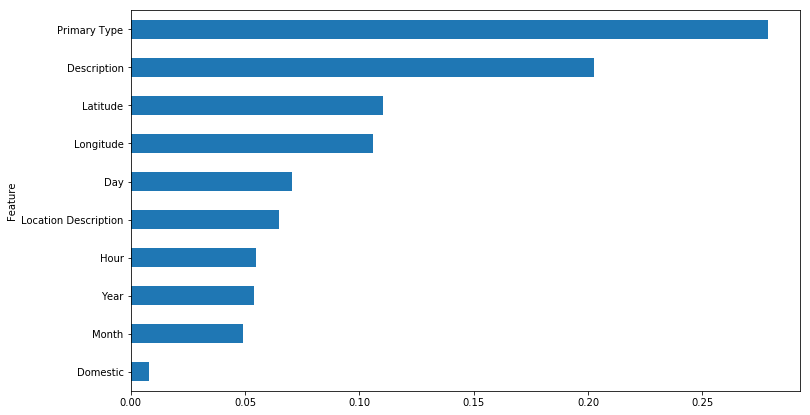

In [67]:
rf_feat_imp.plot('Feature', 'importance', 'barh', figsize=(12, 7), legend=False)
plt.show()

# Type prediciton 

In [7]:
indep_vars = ['Arrest', 'Description', 'Location Description',
       'Domestic', 'Year', 'Latitude', 'Longitude', 'Hour',
       'Day', 'Month']
dep_var = 'Primary Type'

In [8]:
X, y = chicago_crime[indep_vars], chicago_crime[dep_var]

In [9]:
X.head()

,Arrest,Description,Location Description,Domestic,Year,Latitude,Longitude,Hour,Day,Month
60343,0,41,27,0,2019,42.002816,-87.906094,19,3,1
62270,0,55,41,0,2019,41.883369,-87.633860,18,16,3
62611,0,0,34,0,2019,41.825347,-87.606781,22,12,3
62644,0,55,31,0,2019,42.016542,-87.672499,19,14,3
62645,0,43,41,1,2019,41.825299,-87.606961,16,14,3


In [10]:
y.head()

60343    17
62270     2
62611    20
62644     2
62645    15
Name: Primary Type, dtype: int8

### Spitting train and valid

In [14]:
X_sample, y_sample = get_sample(X, y, pctg=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.1)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6260620, 10), (695625, 10), (6260620,), (695625,))

In [17]:
X_train.head()

,Arrest,Description,Location Description,Domestic,Year,Latitude,Longitude,Hour,Day,Month
4488084,0,31,5,0,2007,41.756701,-87.709927,22,9,11
5944517,1,4,3,1,2011,41.792134,-87.670992,9,31,8
3942340,0,22,31,1,2006,41.910417,-87.734893,6,30,8
2371740,0,2,32,0,2003,41.908636,-87.754700,19,30,3
4265264,0,64,3,0,2007,41.925635,-87.697434,1,26,5


## Random forest

In [18]:
rf_type = RandomForestClassifier(n_jobs=-1)

In [19]:
rf_type.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
print_score(rf_type)

In [21]:
pickle.dump(rf_type, open('data/randomforest_type.pkl', 'wb'))

In [ ]:
{'NARCOTICS' : ['NARCOTICS', 'OTHER NARCOTIC VIOLATION']}